In [1]:
import sys, os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings

In [2]:
import yaml

with open("../config.yml", 'r') as f:
    cfg = yaml.safe_load(f)

In [3]:
# warnings.simplefilter('ignore')

import torch
import torchvision

import torch.nn as nn
import torch.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.autonotebook import tqdm
import pickle

from utility.util import one_hot
from utility.train import train
from utility.metrics import print_score, nn_accuracy_score
from utility.torchKernel import NeuralTangentKernel

/home/william/.local/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


# Dataset

In [4]:
seed = cfg['other']['random_seed']

torch.backends.cudnn.enabled = False
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
train_size = cfg['dataset']['train_size']
test_size = cfg['dataset']['test_size']

In [6]:
transform =torchvision.transforms.Compose([
                  torchvision.transforms.ToTensor(),
                  torchvision.transforms.Normalize(
                  (0.1307,), (0.3081,))
                  ])

In [7]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(cfg['dataset']['path'], train=True, download=True,
                             transform=transform),
  batch_size=train_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(cfg['dataset']['path'], train=False, download=True,
                             transform=transform),
  batch_size=test_size, shuffle=True)

In [8]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [9]:
testiter = iter(test_loader)
images_test, labels_test = testiter.next()

Note that the values $0.1307$ and $0.3081$ are the well known mean and variance for the MNIST dataset.

# Network

In [10]:
n_hidden_nodes = 100

MLP = nn.Sequential(nn.Flatten(), nn.Linear(784, n_hidden_nodes),
                    nn.Linear(n_hidden_nodes, n_hidden_nodes), nn.ReLU(),
                    nn.Linear(n_hidden_nodes, n_hidden_nodes), nn.ReLU(),
                    nn.Linear(n_hidden_nodes, 10)).to(device)

MLP_t = nn.Sequential(nn.Flatten(), nn.Linear(784, n_hidden_nodes),
                    nn.Linear(n_hidden_nodes, n_hidden_nodes), nn.ReLU(),
                    nn.Linear(n_hidden_nodes, n_hidden_nodes), nn.ReLU(),
                    nn.Linear(n_hidden_nodes, 10)).to(device)

In [11]:
NTK = NeuralTangentKernel(images, MLP)

NeuralTangentKernel()

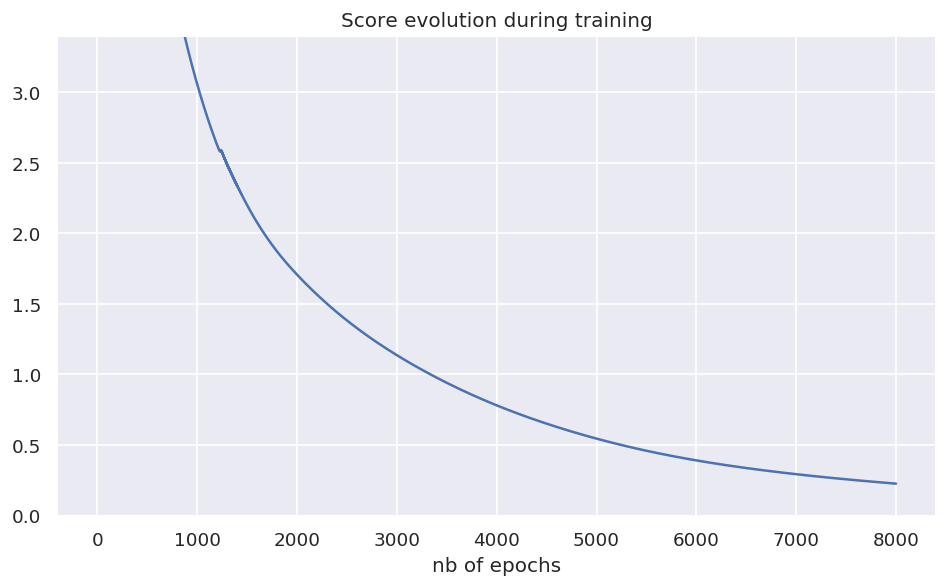

In [12]:
# optimizer = torch.optim.SGD(NTK.parameters(), lr=0.01)
optimizer = torch.optim.Adam(NTK.parameters())
criterion = torch.nn.CrossEntropyLoss()
    
fig_path = cfg['figures']['path']
train(NTK, images, labels, criterion, optimizer, nb_epochs=8000,
      plot_evolution=fig_path+'/train_evolution.png')

In [15]:
if True:
    with open(cfg['models']['path']+'/ntk.pkl', mode='wb') as f:
        pickle.dump(NTK, f)

In [14]:
NTK.train(False)

# print_score(NTK, criterion, images, labels, images_test, labels_test)
print_score(NTK, nn_accuracy_score, images, labels, images_test, labels_test)

<function nn_accuracy_score at 0x7f6efa630a70> on TRAIN :	 0.9660000205039978 
<function nn_accuracy_score at 0x7f6efa630a70> on TEST :	 0.6540000438690186
